# IBM Applied Data Science - Capstone project
## Exercises

### Topic: Predict Car Accident Severity in Seattle, USA

In [ ]:
%reset -f

In [367]:
%matplotlib inline


# import libraries
import pandas as pd 
import numpy as np 
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

import os.path
from IPython.display import clear_output

In [2]:
# get the data

data_url = 'https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'

df = pd.read_csv(data_url)

/Users/martin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# To be run independently
df.info()
#df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    194673 non-null  int64  
 1   X               189339 non-null  float64
 2   Y               189339 non-null  float64
 3   OBJECTID        194673 non-null  int64  
 4   INCKEY          194673 non-null  int64  
 5   COLDETKEY       194673 non-null  int64  
 6   REPORTNO        194673 non-null  object 
 7   STATUS          194673 non-null  object 
 8   ADDRTYPE        192747 non-null  object 
 9   INTKEY          65070 non-null   float64
 10  LOCATION        191996 non-null  object 
 11  EXCEPTRSNCODE   84811 non-null   object 
 12  EXCEPTRSNDESC   5638 non-null    object 
 13  SEVERITYCODE.1  194673 non-null  int64  
 14  SEVERITYDESC    194673 non-null  object 
 15  COLLISIONTYPE   189769 non-null  object 
 16  PERSONCOUNT     194673 non-null  int64  
 17  PEDCOUNT  

In [315]:
# count unique values for a given column

id="SEVERITYCODE"

td = df[id].value_counts().to_frame()

#td.replace('999', np.nan, inplace = True)
#td.loc[('999'),:]
td

,SEVERITYCODE
1,136485
2,58188


In [394]:
# count number of NaNs

def df_qc(df):

    missing_data = df.isnull()
    df_nan = pd.DataFrame(columns=['ID', 'val', 'nan'])

    for column in missing_data.columns.values.tolist():
        try:
            val_ok = missing_data[column].value_counts()[0]
            val_nan = missing_data[column].value_counts()[1]

            df_new_row = pd.DataFrame(data=np.array([[column,val_ok,val_nan]]), columns=['ID','val','nan'])
            df_nan = pd.concat([df_nan,df_new_row], ignore_index=True)

        except:
            val_ok = missing_data[column].value_counts()[0]
            df_new_row = pd.DataFrame(data=np.array([[column,val_ok,0]]), columns=['ID','val','nan'])
            df_nan = pd.concat([df_nan,df_new_row], ignore_index=True)

    # cast values as integer
    df_nan = df_nan.astype({'val' :'int','nan':'int'})

    df_nan.set_index('ID', inplace=True)
    df_nan.sort_values(['nan'], ascending=True, axis=0, inplace=True)

    return df_nan
    #return missing_data["WEATHER"].value_counts()

    

In [395]:
#df["WEATHER"]
df_qc(df)

,val,nan
ID,,
SEVERITYCODE,194673,0
SEGLANEKEY,194673,0
SDOT_COLDESC,194673,0
SDOT_COLCODE,194673,0
INCDTTM,194673,0
INCDATE,194673,0
VEHCOUNT,194673,0
CROSSWALKKEY,194673,0
PEDCOUNT,194673,0


## Clean-up Data and Format

Target value: **SEVERITYCODE**
Goal: Predict severity of accident

* INJURIES: total number of injuries
* SERIOUSINJURIES: total number of serious injuries

* COLLISIONTYPE: how did the cars collide
---
### Participants
* PERSONCOUNT: How many people were involved 
* PEDCOUNT: Number of pedestrians involved
* PEDCYLCOUNT: number of bikes involved
* VEHCOUNT: number of vehicles involved
---
### Nature
* LIGHTCOND / WEATHER / ROADCOND
---
* INCDATE: date of accident
---
### Location
* X / Y: where accident has happened
* LOCATION: exact location

* JUNCTIONTYPE
* CROSSWALKKEY
* SEGLANEKEY: Lane segment
* HITPARKEDCAR
* ADDRTYPE
---
### Fault
* INATTENTIONIND: inattentive or not
* UNDERINFL: influence of narcotics
* PEDROWNOTGRNT: pedestrian right granted?
* SPEEDING
---
### Description
* ST_COLCODE: Description for the accident


# to do
* create number in cars
* create number values for objects 
* convert: UNDERINFL
* create categories
    * years
    * weather and light

* normalize data
* xplot severitydesc and severitycode
* correlation heat map



# Format Data

In [392]:
## 1) Extract Year and Month and create new column

df_c = df.copy()
df_c["YEAR"] = int(df["INCDATE"][0][0:4])
df_c["MONTH"] = int(df["INCDATE"][0][5:7])

## 2) Create from PERSONCOUNT / PEDCOUNT / PEDCYLCOUNT the number of people in cars
# int

df_c["PCAR"] = df["PERSONCOUNT"] - df["PEDCOUNT"] - df["PEDCYLCOUNT"] 
df_c.rename(columns={'PEDCOUNT':'PPED', 'PEDCYLCOUNT':'PCYC'}, inplace=True)

df_c.drop('PERSONCOUNT', inplace= True, axis=1)


In [396]:
def plt_hist_col(data_frame,column_name):
    '''
    Function to plot distribution of unique value counts of a SINGLE COLUMN in a data frame.
    
    INPUT:
    data_frame: Pandas data frame
    column_name: exact column name (STR)
    '''
    
    tot_len = len(data_frame[column_name])
    data_frame_perc = round((pd.Series(data_frame[column_name]).value_counts() / tot_len * 100),3)
    td = data_frame_perc.to_frame()

    ax1 = td.plot(kind="bar", figsize=(14,3), rot=90, width = 0.4)
    ax1.set_yticks(np.arange(0, 110, 10))
    ax1.set_title('Relative distribution of value counts for '+ str(column_name)+'  ('+str(tot_len)+' total)', fontsize=12)
    
    for p in ax1.patches:
        ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() + 2), fontsize=10, color="r")
    plt.show()
    
    return(ax1)

        

    

def df_type_qc(data_frame_r, verbose=True):
    
    '''
    Function to interactively QC all column data types and cast them into other types if required.
    Returns a list del_list with column names to be deleted in next step.
    
    INPUT:
    data_frame_r: Pandas data frame
    verbose=True: Output of statistics True/False (BOOLEAN)
    OUTPUT:
    data_frame: QCed data frame
    del_list: List with column names to be deleted
    '''
    
    data_frame = data_frame_r.copy() # copy input df
    hist_max = 50 # number of maximum unique values to plot histogram
    del_list = [] # list with columns to be deleted
    i = 0
    cast = ""
    
    len_df = len(data_frame.columns) # number of columns
    missing_data = data_frame.isnull() # count missing data and create df with True/False
    
    # iterate through all columns and check data type
    # user input to cast into different data type
    
    while i < (len_df) and cast != "x": # total number of columns
        col_name = str(data_frame.columns[i]) #column name
        
        
        
        # calculate missing data per column
        val_nan = 0
        val_ok = 0
        
        try:
            val_ok = missing_data[col_name].value_counts()[0]
            val_nan = missing_data[col_name].value_counts()[1]
            tot_count = len(data_frame[col_name])

        except:
            val_ok = missing_data[col_name].value_counts()[0]
            tot_count = len(data_frame[col_name])
 
        # if verbose=True output 
        if verbose:
            clear_output()
            print(f"{i+1}/{len_df}: {col_name}")
            #print("----------STATS----------")
            print(f"\ttotal:\t{tot_count}")
            print(f"\tOK:\t{val_ok}\t({val_ok/tot_count*100}%)")
            print(f"\tNaN:\t{val_nan}\t({val_nan/tot_count*100}%)")
            
            print("----------HEAD----------")
            print(f"{data_frame[col_name].head()}\n")
            #random.randint(0,100)
            
            
            if len(data_frame[col_name].value_counts()) <= hist_max:              
                plt_hist_col(data_frame,col_name)
            
        print(f"x: quit\ni: cast to INT\nf: cast to FLT\no: cast to OBJ\nd: mark to DELETE (add to del_list)\nelse: skip")
        cast = input(">>")
              
        
        if cast == "i":
            data_frame[[col_name]] = data_frame[[col_name]].astype("int64", errors='ignore')
        elif cast == "f":
            data_frame[[col_name]] = data_frame[[col_name]].astype("float64", errors='ignore')
        elif cast == "o":
            data_frame[[col_name]] = data_frame[[col_name]].astype("object", errors='ignore')
        elif cast == "d":
            del_list.append(col_name)

        else:
            pass 
        
    
        i += 1

    return (data_frame,del_list) # return QCed df and list with column names to be deleted




40/40: PCAR
	total:	194673
	OK:	194673	(100.0%)
	NaN:	0	(0.0%)
----------HEAD----------
0    2
1    2
2    4
3    3
4    2
Name: PCAR, dtype: int64



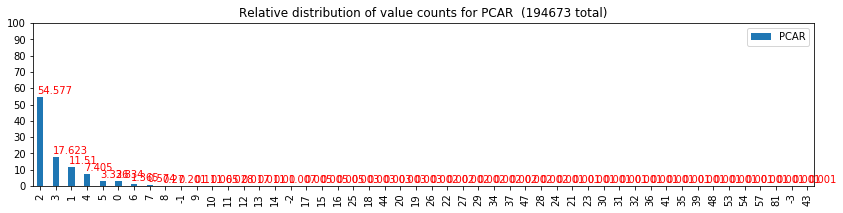

x: quit
i: cast to INT
f: cast to FLT
o: cast to OBJ
d: mark to DELETE (add to del_list)
else: skip
>>d


In [397]:
df_c_qc,del_list = df_type_qc(df_c)

In [398]:
del_list

['INTKEY',
 'EXCEPTRSNCODE',
 'EXCEPTRSNDESC',
 'INCDATE',
 'INCDTTM',
 'INATTENTIONIND',
 'PEDROWNOTGRNT',
 'SDOTCOLNUM',
 'SPEEDING',
 'PCAR']

In [302]:
df_c["WEATHER"].describe(include=all)

count     189592
unique        11
top        Clear
freq      111135
Name: WEATHER, dtype: object

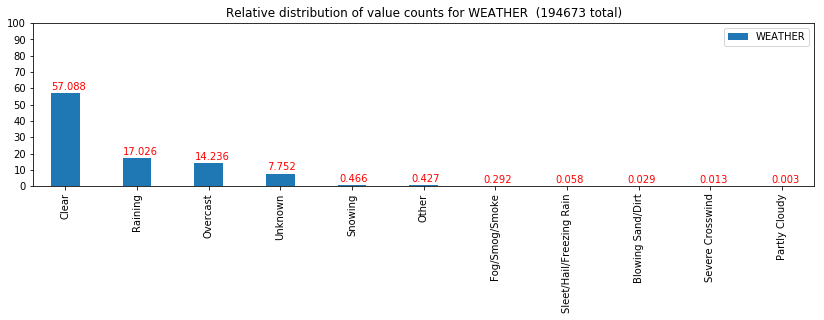

In [228]:
plt_hist_col(df_c,"WEATHER")

## 3) convert value into integer


#id="WEATHER"

# make sure no NaN values
#temp_df = df_c[id].fillna(0)


#tempd2 = pd.DataFrame(pd.factorize(temp_df)[0])

#out = pd.concat([df_c[id], tempd2], axis=1, sort=False)
#out["WEATHER"]

In [ ]:
# Function to condition column values

def cond_c(df_raw2, column_names, kill_nan=False, replace_nan=["no"], int_trans=False, verbose=True, d_info=True):
    
    df_raw = df_raw2.copy()
    
    '''
    clean df values and transform
    INPUT:
    df_raw: full data frame
    column_names: LIST of column names to be QCed
    kill_nan=False: remove NaN from data frame (True/False)
    replace_nan="no": LIST if kill_nan == False, possibility to replace with value or mean/median/str/value. 
                      replace_nan=no: do not touch; leave unchanged
    int_trans=True: convert uniques obj into integer. add new column called column_names[n]_INT and rename old one 
                    with prefix "_"
    verbose=True: output info of nans and d_info: number of unique values
    d_info=True: number of unique values
    '''
 

    for n,i in enumerate(column_names):
        # get number of missing entries
        missing_data = df_raw[column_names[n]].isna().sum()
        num_rows = df_raw.shape[0]
        perc_nan = round(missing_data / num_rows * 100,2)
    
# output column info if verbose True
        if verbose:
            print(f"\n{column_names[n]}")
            print("\r---------------------------------------------------")
            print(f"Number of missing entries: {missing_data} ({perc_nan} % of entries)")
            print("\r---------------------------------------------------")

            if d_info:
                print(df_raw[column_names[n]].value_counts())
                print("")
            else:
                pass
        else:
            pass
        
        
# kill rows in whole data frame if nan value
        if kill_nan:
            df_raw = df_raw[df_raw[column_names[n]].notna()]  
            int_flag = True
        else:
            pass

       
    
# fill NaN rows in df. 
# the if loop checks the type of the values and allow to replace them eventually with calculated median/mean
# or provided str/int/float

        # don't do anything
        if replace_nan[n] == "no":
            int_flag = False
            
            if verbose:
                print(f">> {column_names[n]} nothing replaced.")

        # replace NaN with median
        elif replace_nan[n] == "median" and (df_raw[column_names[n]].dtypes == "float64" or df_raw[column_names[n]].dtypes == "int64"):
 
            av = df_raw[column_names[n]].median()
            df_raw[column_names[n]] = df_raw[column_names[n]].replace(np.nan, av)
            if verbose:
                print(f">> {column_names[n]} NaN replaced with median ({missing_data} values).")
            int_flag = False 

        # replace NaN with mean
        elif replace_nan[n] == "mean" and (df_raw[column_names[n]].dtypes == "float64" or df_raw[column_names[n]].dtypes == "int64"):
            
            av = df_raw[column_names[n]].mean()
            df_raw[column_names[n]] = df_raw[column_names[n]].replace(np.nan, av)
            
            if verbose:
                print(f">> {column_names[n]} NaN replaced with mean ({missing_data} values).")
            int_flag = False 
            
        # replace NaN with provided float or integer                                               
        elif (isinstance(replace_nan[n], int) or isinstance(replace_nan[n], float)) and (df_raw[column_names[n]].dtypes == "float64" or df_raw[column_names[n]].dtypes == "int64"):

            df_raw[column_names[n]] = df_raw[column_names[n]].replace(np.nan, replace_nan[n])
            
            if verbose:
                print(f">> {column_names[n]} NaN replaced with \"{replace_nan[n]}\" ({missing_data} values).")
            int_flag = False
        
        # replace NaN with provided string
        elif isinstance(replace_nan[n], str) and df_raw[column_names[n]].dtypes == "O":
            
            df_raw[column_names[n]] = df_raw[column_names[n]].replace(np.nan, replace_nan[n])
            
            if verbose:
                print(f">> {column_names[n]} NaN replaced with \"{replace_nan[n]}\" ({missing_data} values).")
            int_flag = True
        
        # if type does not match, pass.
        else:
            if verbose:
                print(f"!! replace_nan = {replace_nan[n]} does not fit column type {df_raw[column_names[n]].dtypes}. pass")
            int_flag = False
            pass

                
            
# replace obj-type entries as unique integers and add new column to df with name column_names[n]_INT
    
        if int_trans and int_flag and df_raw[column_names[n]].dtypes == "O":
            temp = pd.DataFrame(pd.factorize(df_raw[column_names[n]])[0])
            temp.columns = [(column_names[n] + "_INT")]
            df_raw = pd.concat([df_raw, temp], axis=1, sort=False)

            df_raw.rename(columns={column_names[n] : ('_' + column_names[n])}, inplace=True)
            
            if verbose:
                print(f">> Unique column values counted and added.")
                print(f"\t-- New column created of type <int> \"{column_names[n]}_INT\" from unique values in \"{column_names[n]}\"")
                print(f"\t-- Column ID \"{column_names[n]}\" renamed to \"_{column_names[n]}\"")
            

        else:
            pass
        
        
        
    return df_raw
    
    
    

    

In [ ]:
out = cond_c(df_c,column_names = ["LOCATION"], kill_nan=False, replace_nan=["Unknown"], int_trans = True, verbose=True,d_info=True)
cond_c(out,column_names = ["_LOCATION"])
#cond_c(d,column_names = ["WEATHER"], kill_nan=False, verbose=True,d_info=True)

In [ ]:
d[["WEATHER_INT","_WEATHER"]].head(20)

In [ ]:
## 4) convert UNDERINFL into int
# ROADCOND Unknown to Other 
# LIGHTCOND Unknown to Other
# HITPARKEDCAR to Int

In [ ]:
## 5) convert 